In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Example 00: Two-link

Integrating two-link, using variational integrator based on Discrete Euler-Lagrange


# Problem definition


In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from varitop.integrator import DelIntegrator
from varitop.problem import VaritopProblem
from varitop.misc import euler_quadrature

import casadi as cs
import numpy as np

Matplotlib created a temporary cache directory at /tmp/matplotlib-pzwn5m5u because the default path (/home/mambauser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
steps = 50
t0 = 0
tf = 1
tspan = [t0, tf]
ts = np.linspace(t0, tf, steps)
dt = (tspan[1] - tspan[0]) / steps

q_0 = np.array(
    [
        0,
        0,
        0,
        1,
        -1 * np.sin(np.pi / 3),
        1 * np.cos(np.pi / 3) + 1,
    ]
)

In [4]:
nodes = 50
problem = VaritopProblem()
problem.set_nodes(nodes)
problem.set_quadrature(euler_quadrature)

In [5]:
qs = problem.create_state("q", 6)
vs = problem.create_velocity("v", 6)

In [6]:
q, v = qs[0], vs[0]

In [7]:
kinetic_energy = cs.Function("kinetic", [q, v], [0.5 * v.T @ v])
potential_energy = cs.Function("potential", [q, v], [9.81 * (q[1] + q[3] + q[5])])
total_energy = cs.Function(
    "total", [q, v], [kinetic_energy(q, v) + potential_energy(q, v)]
)
lagrangian = cs.Function("L", [q, v], [kinetic_energy(q, v) - potential_energy(q, v)])
momentum = cs.Function("momentum", [q, v], [cs.jacobian(kinetic_energy(q, v), v)])

In [8]:
phi0 = cs.Function("phi0", [q], [q[0]])
phi1 = cs.Function("phi1", [q], [q[1]])
phi2 = cs.Function("phi2", [q], [(q[0] - q[2]) ** 2 + (q[1] - q[3]) ** 2 - 1])
phi3 = cs.Function("phi3", [q], [(q[2] - q[4]) ** 2 + (q[3] - q[5]) ** 2 - 1])

In [9]:
phis = cs.Function("phis", [q, v], [phi0(q), phi1(q), phi2(q), phi3(q)])

Multiple constraints of the same type will be concatenated inside for an efficiency.


In [10]:
problem.add_constraints("=", [phi0])
problem.add_constraints("=", [phi1, phi2, phi3])

In [11]:
problem.set_continuous_lagrangian(lagrangian)

# Single Step - Multiple Substeps


Composition method of composing several lagrangians together. In this particular instance we are assuming we are solving the problem of span $[0, 1]$ seconds with only one step, but `nodes` substeps.


In [12]:
cdel_res = problem.get_composite_del_residual()
cdel_res

Function(composition:(q[50x6],lambda[48x4])->(residual[1x480]) SXFunction)

In [13]:
q_guess = np.full((nodes, 6), q_0)  # q0 for all nodes
q_guess = np.reshape(q_guess, (-1, 1))
lambda_guess = np.zeros(
    ((nodes - 2) * 4, 1)
)  # 4 constraints per node, except two first

In [14]:
q_sol = cs.SX.sym("q_sol", (nodes, 6))
lambdas = cs.SX.sym("lambdas", (nodes - 2, 4))
qst = q_sol.T.reshape((-1, 1))
lst = lambdas.T.reshape((-1, 1))
var = cs.vcat([qst, lst])

nlp = {
    "x": var,
    "f": 0,
    "g": cs.hcat(
        [cdel_res(q_sol, lambdas), (q_sol[0, :].T - q_0).T, (q_sol[1, :].T - q_0).T]
    ),
}
solver = cs.nlpsol("solver", "ipopt", nlp)
res = solver(x0=[*q_guess, *lambda_guess], lbg=0, ubg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2202
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      856

Total number of variables............................:      492
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      492
Total number of inequality c

In [15]:
x_opt = np.array(res["x"])
qs_sol = np.array(x_opt[: 6 * nodes].reshape((nodes, 6)))

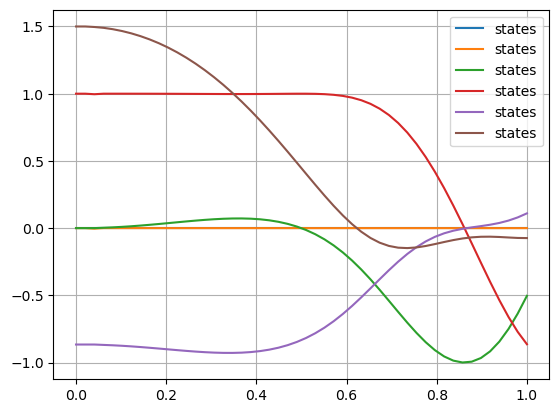

In [16]:
plt.plot(ts, qs_sol, label="states")
plt.grid()
plt.legend()
plt.show()

In [17]:
dqs = np.zeros((steps, 6))
dqs[0, :] = np.zeros(6)
for i in tqdm(range(1, steps)):
    dqs[i, :] = (qs_sol[i, :] - qs_sol[i - 1, :]) / dt

100%|██████████| 49/49 [00:00<00:00, 68874.29it/s]


In [18]:
ks = np.zeros(steps)
es = np.zeros(steps)
tes = np.zeros(steps)
for i in tqdm(range(steps)):
    ks[i] = kinetic_energy(qs_sol[i, :], dqs[i, :])
    es[i] = potential_energy(qs_sol[i, :], dqs[i, :])
    tes[i] = total_energy(qs_sol[i, :], dqs[i, :])

100%|██████████| 50/50 [00:00<00:00, 5927.84it/s]


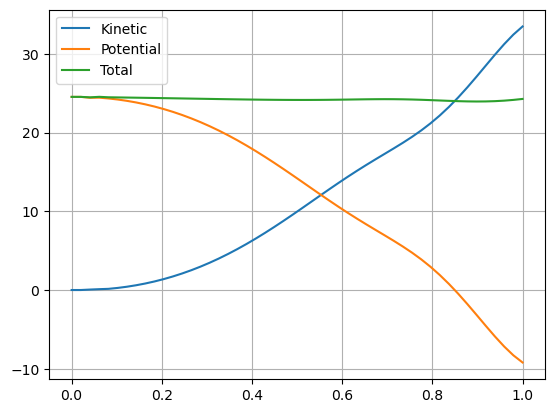

In [19]:
plt.plot(ts, ks, label="Kinetic")
plt.plot(ts, es, label="Potential")
plt.plot(ts, tes, label="Total")
plt.grid()
plt.legend()
plt.show()

# Double-check with DEL


In [20]:
del_constraint = problem.get_del_residual()
del_constraint

Function(DEL:(q-1[10],q[6],q+1[6],dt)->(DEL_residual[10]) SXFunction)

In [21]:
del_int = DelIntegrator()
del_int.set_del(del_constraint)
del_int.set_time(tspan, steps)
del_int.set_initial(q_0)
del_int.add_metric([kinetic_energy, potential_energy, total_energy, momentum, phis])

In [22]:
del_hist = del_int.solve()

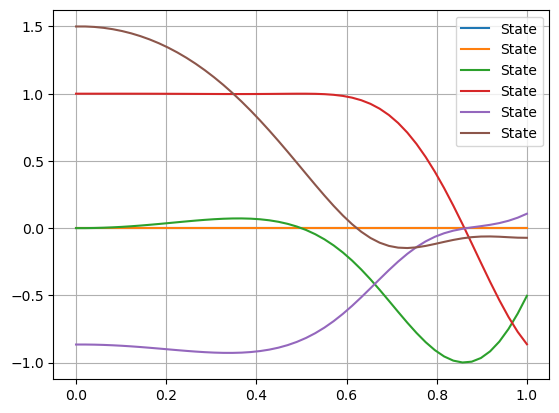

In [23]:
plt.plot(ts, del_hist["state"], label="State")
plt.grid()
plt.legend()
plt.show()

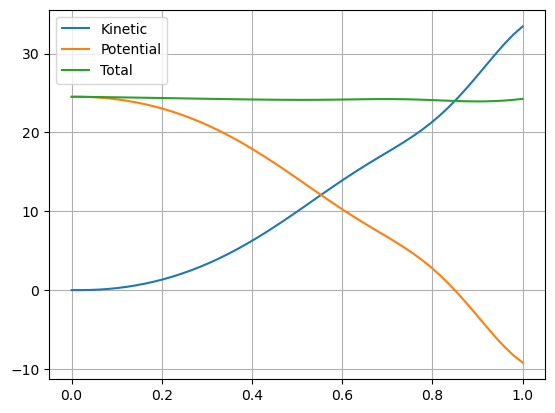

In [24]:
plt.plot(ts, del_hist["kinetic"], label="Kinetic")
plt.plot(ts, del_hist["potential"], label="Potential")
plt.plot(ts, del_hist["total"], label="Total")
plt.grid()
plt.legend()
plt.show()